# ***Libraries***

In [1]:
import math
import os
import sys
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
sys.path.append(parent_dir)

In [4]:
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length, plotFig, printResult

from TSB_UAD.models.iforest import IForest

# ***Non-Streaming Methods***
We pick two non-streaming methods of our choice as a baseline (e.g., Isolation Forest and a DNN
method). We run the methods on the files of the dictionary we created in an eariler step. In the no streaming setting we use the entire generated files as input. These methods will serve as our offline baselines.


## ***Data Pre-Processing***

In [5]:
# Load the Time-Series dictionary
with open('Time-Series-Data-Dictionary.json', 'r') as json_file:
    loaded_dict = json.load(json_file)

In [6]:
for filename, info in loaded_dict.items():
    print(f'{filename}: {info}')

ts1: ['Normality_1', 'MGAB']
ts2: ['Normality_2', 'SVDB', 'Dodgers']
ts3: ['Normality_2', 'SMD', 'Dodgers']
ts4: ['Normality_1', 'Daphnet']
ts5: ['Normality_1', 'NAB']
ts6: ['Normality_2', 'KDD21', 'GHL']
ts7: ['Normality_3', 'MITDB', 'IOPS', 'Occupancy']
ts8: ['Normality_1', 'ECG']
ts9: ['Normality_1', 'NASA-MSL']
ts10: ['Normality_2', 'Occupancy', 'NAB']
ts11: ['Normality_3', 'SVDB', 'IOPS', 'Occupancy']
ts12: ['Normality_3', 'Genesis', 'IOPS', 'SensorScope']
ts13: ['Normality_3', 'Occupancy', 'Dodgers', 'SensorScope']
ts14: ['Normality_2', 'GHL', 'SMD']
ts15: ['Normality_3', 'SVDB', 'ECG', 'SensorScope']


In [7]:
preprocessed_dict = {}

In [8]:
for filename, info in loaded_dict.items():
    ts_filepath = f"TS-Data-Files/{filename}"
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised method
    ts = pd.read_csv(ts_filepath, header=None).dropna().to_numpy()

    name = ts_filepath.split('/')[-1]
    max_length = ts.shape[0]

    data = ts[:max_length, 0].astype(float)
    label = ts[:max_length, 1]

    slidingWindow = find_length(data)
    X_data = Window(window=slidingWindow).convert(data).to_numpy()

    # Prepare data for semisupervised method. 
    # Here, the training ratio = 0.1

    data_train = data[:int(0.1 * len(data))]
    data_test = data

    X_train = Window(window=slidingWindow).convert(data_train).to_numpy()
    X_test = Window(window=slidingWindow).convert(data_test).to_numpy()

    print(f'Time-Series filename: {filename}')
    print("Estimated Subsequence length: ", slidingWindow)
    print()
    
    # Store the pre-processed variables in the new dictionary
    preprocessed_dict[filename] = {
        'name': name,
        'data': data,
        'label': label,
        'slidingWindow': slidingWindow,
        'X_data': X_data,
        'data_train': data_train,
        'data_test': data_test,
        'X_train': X_train,
        'X_test': X_test,
        'Time series length': len(data),
        'Number of abnormal points': list(label).count(1)
    }

Time-Series filename: ts1
Estimated Subsequence length:  125

Time-Series filename: ts2
Estimated Subsequence length:  125

Time-Series filename: ts3
Estimated Subsequence length:  88

Time-Series filename: ts4
Estimated Subsequence length:  125

Time-Series filename: ts5
Estimated Subsequence length:  6

Time-Series filename: ts6
Estimated Subsequence length:  125

Time-Series filename: ts7
Estimated Subsequence length:  103

Time-Series filename: ts8
Estimated Subsequence length:  88

Time-Series filename: ts9
Estimated Subsequence length:  269

Time-Series filename: ts10
Estimated Subsequence length:  125

Time-Series filename: ts11
Estimated Subsequence length:  72

Time-Series filename: ts12
Estimated Subsequence length:  125

Time-Series filename: ts13
Estimated Subsequence length:  88

Time-Series filename: ts14
Estimated Subsequence length:  288

Time-Series filename: ts15
Estimated Subsequence length:  36



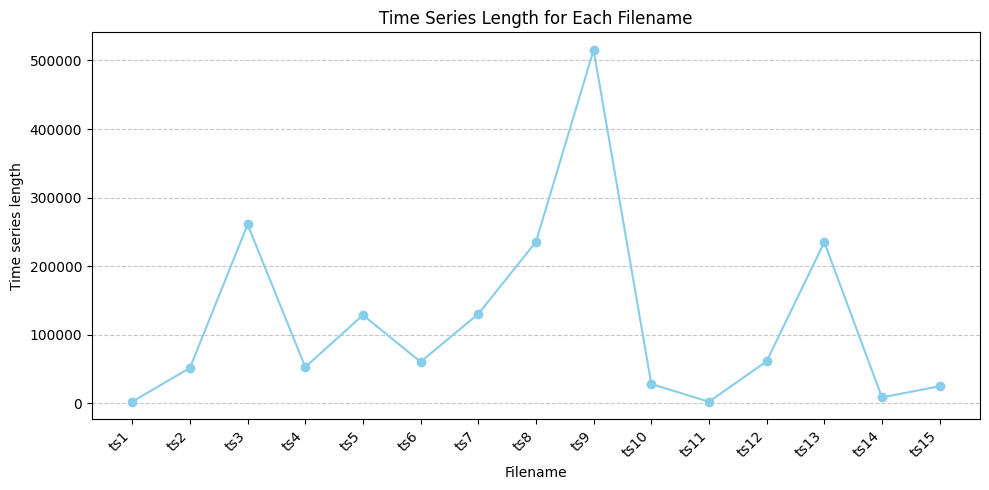

In [9]:
# Get filenames, time series lengths, and number of abnormal points
filenames = list(preprocessed_dict.keys())
time_series_lengths = [data['Time series length'] for data in preprocessed_dict.values()]
number_of_abnormal_points = [data['Number of abnormal points'] for data in preprocessed_dict.values()]

# Plot 'Time series length' and 'Number of abnormal points' for each filename
plt.figure(figsize=(10, 5))
plt.plot(filenames, time_series_lengths, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Filename')
plt.ylabel('Time series length')
plt.title('Time Series Length for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

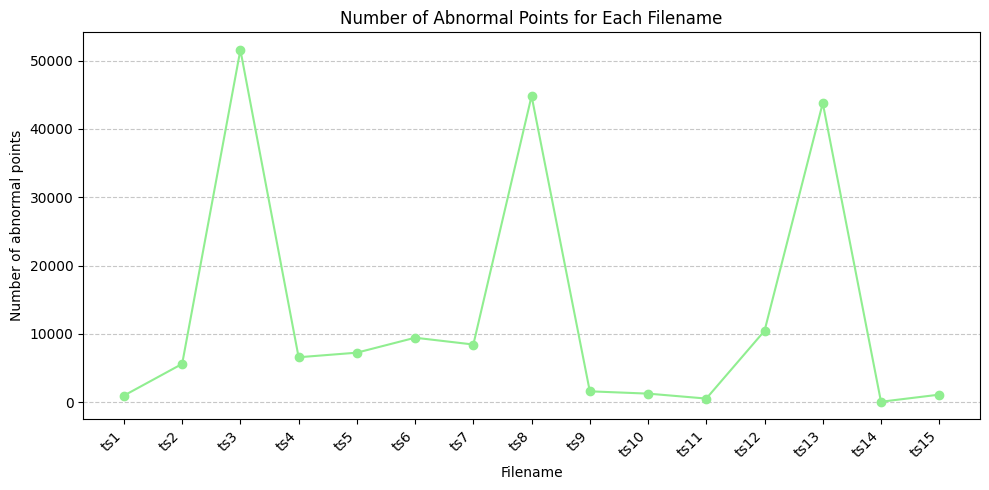

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(filenames, number_of_abnormal_points, marker='o', linestyle='-', color='lightgreen')
plt.xlabel('Filename')
plt.ylabel('Number of abnormal points')
plt.title('Number of Abnormal Points for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## ***Anomaly Detection***

### ***Isolation Forest***

In [9]:
from tqdm.notebook import tqdm_notebook as tqdm

modelName = 'IForest'
clf = IForest(n_jobs=10)

In [25]:
results = []

for filename in tqdm(preprocessed_dict.keys()):
    ts = preprocessed_dict[filename]
    x = ts['X_data']
    
    clf.fit(x)
    score = clf.decision_scores_
    
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    score = np.array([score[0]]*math.ceil((ts['slidingWindow']-1)/2) + list(score) + [score[-1]]*((ts['slidingWindow']-1)//2))
    
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    results.append([filename] + L)

  0%|          | 0/15 [00:00<?, ?it/s]

In [26]:
# columns = ['Filename'] + [f'Metric_{i+1}' for i in range(len(results[0])-1)]
columns = ['Filename'] + ['AUC', 'Precision', 'Recall', 'F-score', 'Range-recall', 'ExistenceReward', 'OverlapReward', 'Range-precision', 'Range-Fscore', 'Precison@k', 'RangeAUC']
df = pd.DataFrame(results, columns=columns)

In [27]:
df

,Filename,Metric_1,Metric_2,Metric_3,Metric_4,Metric_5,Metric_6,Metric_7,Metric_8,Metric_9,Metric_10,Metric_11
0,ts1,0.846668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.991952
1,ts2,0.761741,0.027397,0.007126,0.011311,0.009570,0.014925,0.008231,0.013699,0.011268,0.007126,0.884947
2,ts3,0.741644,0.385664,0.076270,0.127354,0.020308,0.032353,0.017297,0.237311,0.037415,0.076270,0.778276
3,ts4,0.730383,0.820325,0.153250,0.258254,0.091754,0.095890,0.090719,0.223533,0.130104,0.153250,0.855230
4,ts5,0.980492,0.240138,0.047836,0.079779,0.432802,0.600000,0.391003,0.294158,0.350259,0.047836,0.980571
5,ts6,0.756021,0.000689,0.000106,0.000184,0.041667,0.041667,0.041667,0.000689,0.001355,0.000106,0.713272
6,ts7,0.924921,0.641710,0.264796,0.374895,0.101435,0.272727,0.058612,0.354710,0.157757,0.264796,0.872704
7,ts8,0.754599,0.410836,0.033662,0.062226,0.043732,0.043732,0.043732,0.051773,0.047414,0.033662,0.806866
8,ts9,0.852455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.894936
9,ts10,0.850042,0.200549,0.173672,0.186145,0.116836,0.400000,0.046045,0.185185,0.143277,0.173672,0.851446


### ***STUMP***

In [10]:
import stumpy
modelName = 'STUMP'

In [12]:
results = []

for filename in tqdm(preprocessed_dict.keys()):
    ts = preprocessed_dict[filename]
    full_ts = ts['data']
    subseries = ts['X_data']
    window_size = ts['slidingWindow']
    slidingWindow = window_size

    k = 1
    score_ = stumpy.stump(T_A=full_ts, m=window_size, k=k, ignore_trivial=True, normalize=True)
    
    score = score_.T[k-1]
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score_.T[k-1].reshape(-1,1)).ravel()
    score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    results.append([filename] + L)

  0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
columns = ['Filename'] + ['AUC', 'Precision', 'Recall', 'F-score', 'Range-recall', 'ExistenceReward', 'OverlapReward', 'Range-precision', 'Range-Fscore', 'Precison@k', 'RangeAUC']
df = pd.DataFrame(results, columns=columns)
df

,Filename,AUC,Precision,Recall,F-score,Range-recall,ExistenceReward,OverlapReward,Range-precision,Range-Fscore,Precison@k,RangeAUC
0,ts1,0.967603,1.000000,0.003086,0.006154,0.014911,0.071429,0.000782,1.000000,0.029385,0.003086,0.998087
1,ts2,0.374253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.725616
2,ts3,0.547222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.604408
3,ts4,0.368520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.698458
4,ts5,0.494283,0.042857,0.000414,0.000819,0.004002,0.020000,0.000003,0.042857,0.007321,0.000414,0.488210
5,ts6,0.450480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.476641
6,ts7,0.911148,0.459754,0.229877,0.306503,0.105957,0.409091,0.030174,0.387665,0.166426,0.229877,0.909841
7,ts8,0.522824,0.332193,0.023824,0.044460,0.056075,0.206997,0.018345,0.321447,0.095492,0.023824,0.599467
8,ts9,0.906643,0.057340,0.752816,0.106564,0.756984,0.846154,0.734692,0.046544,0.087696,0.000000,0.921444
9,ts10,0.452329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.476471
